## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. Use fixed parameters. <br>
Run one bird at a time

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
bd = 'pair4RigBCU53'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,8.5]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use
rn = 'spec_goffinet_nn_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
fd_save = os.path.join(fd_data, bd, 'UMAPonVAE7', sylStr, rn)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/UMAPonVAE7/v/spec_goffinet_nn_256_176


In [6]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'cosine'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20, 'select_method':'leaf'}

## 2. Train VAE, obtain latent features

In [7]:
print(f'Processing for {bd} {rn}...')
print(f'Save results to {fd_save}')
## load spectrograms and meta info
fn_spec = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.h5')
fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
with h5py.File(fn_spec, 'r') as f:
    spec_win_all = f['spec_win_all'][:]  #

info = pd.read_csv(fn_info, index_col=0)

print(spec_win_all.shape, info.shape)

Processing for pair4RigBCU53 spec_goffinet_nn_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/UMAPonVAE7/v/spec_goffinet_nn_256_176
(16194, 128, 128) (16194, 7)


In [8]:
## train VAE network
# create dataloader from h5 file
# train_data = vae_goffinet.SpecDataset(fn_spec)
# # set a random seed
# g = torch.Generator()
# g.manual_seed(42)
# train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
# loaders = {'train':train_dataloader, 'test':train_dataloader}

# # init VAE model then train
# model = vae_goffinet.VAE(save_dir=fd_save)
# model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

# OR load previously trained model
# for training see ZZp3_UMAPonVAE_v1.ipynb
fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
model = vae_goffinet.VAE(save_dir=fd_save)
model.load_state(fn_model)

In [9]:
## Obtain latent representation
train_data = vae_goffinet.SpecDataset(fn_spec)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

# loop through dataloader, obtain model latent space
latent_m = np.zeros((info.shape[0], 32))
latent_d = np.zeros((info.shape[0], 32))
recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data.to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = rec.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        recon[count:(count+a),:,:] = rec
        count += a

# save the latent representations
fn_latentM = os.path.join(fd_save, 'latentM.csv')
np.savetxt(fn_latentM, latent_m, delimiter=',')
fn_latentD = os.path.join(fd_save, 'latentD.csv')
np.savetxt(fn_latentD, latent_d, delimiter=',')
print(latent_m.shape)

0it [00:00, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
254it [00:18, 13.95it/s]


(16194, 32)


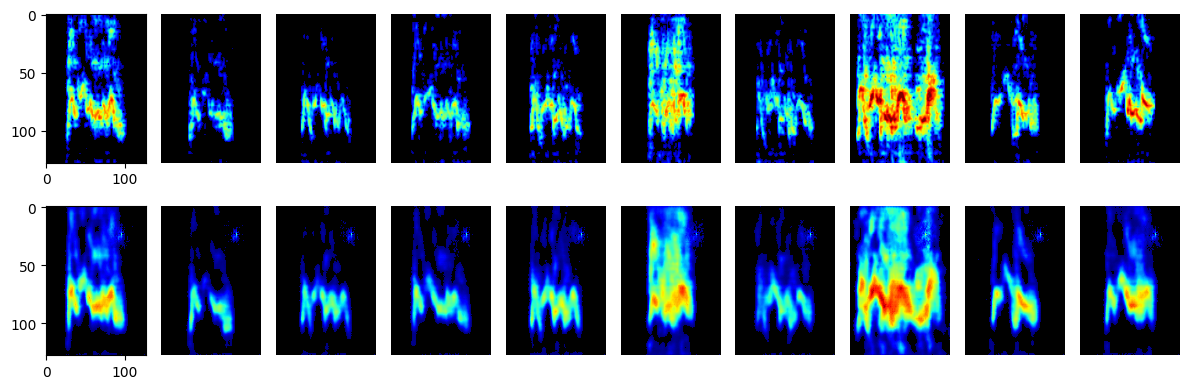

In [10]:
## check recontruction accuracy (optional)
# plot some random samples
fig, ax = plt.subplots(2, 10, figsize=[12,4])
random.seed(1118)
random_i = random.sample(list(range(recon.shape[0])), 10)
with h5py.File(fn_spec, 'r') as file:
    for ii in range(10):
        spec = train_data[random_i[ii],:,:].numpy()
        ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        spec = recon[random_i[ii],:,:]
        ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        if ii>0:
            ax[0][ii].axis('off')
            ax[1][ii].axis('off')
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
fig.savefig(fn_fig)


## 3. Run UMAP/HDBSCAN

In [7]:
fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
info = pd.read_csv(fn_info, index_col=0)

In [8]:
# read latent features
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(16194, 32)

In [9]:
# add latent_m to the embedding data frame
embed = info.copy()
for ii in range(latent_m.shape[1]):
    embed[f'vae{ii}'] = latent_m[:,ii]

### UMAP

In [10]:
## run UMAP 
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_m)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'cosine'}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Thu Jul  3 16:23:25 2025 Construct fuzzy simplicial set
Thu Jul  3 16:23:25 2025 Finding Nearest Neighbors
Thu Jul  3 16:23:25 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Thu Jul  3 16:23:27 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Jul  3 16:23:35 2025 Finished Nearest Neighbor Search
Thu Jul  3 16:23:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul  3 16:23:44 2025 Finished embedding


In [11]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Thu Jul  3 16:23:47 2025 Worst tree score: 0.82623194
Thu Jul  3 16:23:47 2025 Mean tree score: 0.83119449
Thu Jul  3 16:23:47 2025 Best tree score: 0.83821168
Thu Jul  3 16:23:48 2025 Forward diversification reduced edges from 404850 to 137785
Thu Jul  3 16:23:50 2025 Reverse diversification reduced edges from 137785 to 137785
Thu Jul  3 16:23:52 2025 Degree pruning reduced edges from 151420 to 151420
Thu Jul  3 16:23:52 2025 Resorting data and graph based on tree order
Thu Jul  3 16:23:52 2025 Building and compiling search function


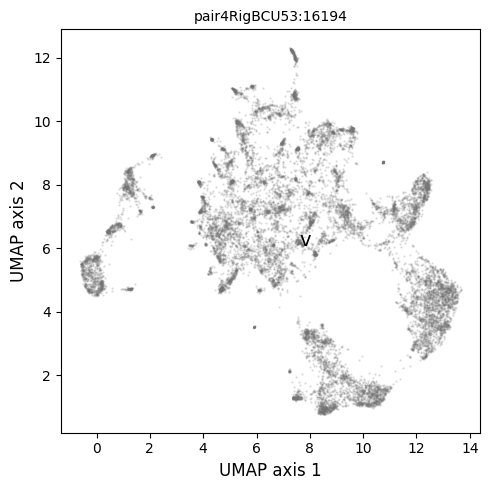

In [12]:
## plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c='#737373')
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.UMAPonVAE.embedding.pdf')
fig.savefig(fn_fig)

### HDBSCAN clustering

In [13]:
res.shape[0] * 0.05

809.7

In [14]:
## HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
#                             cluster_selection_method=param_hdbscan['select_method'])
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=20, 
                            cluster_selection_method='leaf', prediction_data=True)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
clusterer.fit(res)
embed['hdbscan_cluster'] = clusterer.labels_ + 1    # no clustering is label 0
embed['hdbscan_prob'] = clusterer.probabilities_

# save embedding and clustering 
fn_embed = os.path.join(fd_save, f'{bd}.{rn}.embedding.csv')
embed.to_csv(fn_embed)

# what's the fraction that's not clustered
unc_f = embed[embed['hdbscan_cluster']==0].shape[0] / embed.shape[0]
print(f'The fraction that are not clustered: {unc_f:.4f}')
num_c = max(embed['hdbscan_cluster'])
print(f'Total number of clusters: {num_c}')

The fraction that are not clustered: 0.2173
Total number of clusters: 7


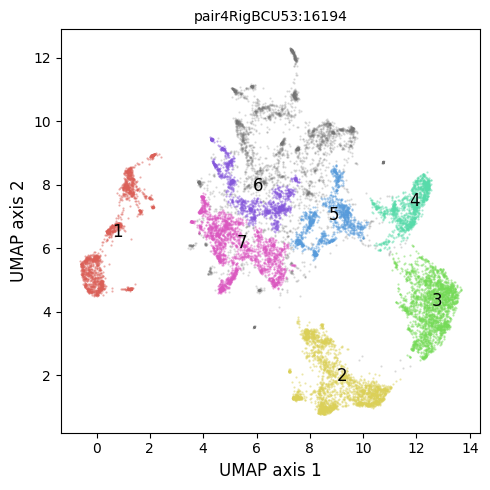

In [16]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster']))
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan_cluster'])+1):
    embed_s = embed[embed['hdbscan_cluster']==hi]
    if hi==0:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi-1])
        # add syl label
        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [17]:
# save HDBSCAN model for future use
fn_cluster = os.path.join(fd_save, f'HDBSCANmodel_{bd}.p')
pickle.dump(clusterer, open(fn_cluster, 'wb'))

In [18]:
# save the color list as well
col_long_np = np.array(col_long)
fn_col = os.path.join(fd_save, 'color.txt')
np.savetxt(fn_col, col_long_np, delimiter=',')

### Quantify clustering quality

In [23]:
## Quantify clustering tendency
# in UMAP space
hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
print(f'Hopkins metric in UMAP: {hpk1:.4f}')
# in VAE space
hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
print(f'Hopkins metric in VAE: {hpk2:.4f}')

## Quantify clustering quality with Silhoutte score
# in UMAP space
sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
# in VAE space
sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

# Calinski–Harabasz (CH) Index
cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

# save data to the master data frame
metrics = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])

Hopkins metric in UMAP: 0.9754
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3901
HDBSCAN Silhouette score in VAE: 0.0333
Calinski–Harabasz index in UMAP: 17753.6465
Calinski–Harabasz index in VAE: 660.3540


In [24]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigBCU53,spec_goffinet_nn_256_176,7,0.217303,"[0.23435784102389948, 0.49574206134052906, 0.6...",0.97538,0.824799,0.390083,0.033273,17753.646534,660.354005,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 4. Simulate the random datasets

In [37]:
# number of trials to simulate
n = 200

In [38]:
# load the real dataset
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(16194, 32)

In [39]:
 # estimated mean and variance
mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
Sigma  = np.cov(latent_m, rowvar=False, ddof=1)

In [ ]:
# save metrics in a master dataframe
metrics = pd.DataFrame()
np.random.seed(1118)
for i in range(n):
# for i in range(2):
    rng = np.random.default_rng()  
    latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
    
    # then run UMAP and HDBSCAN exactly as for real datasets
    ## run UMAP 
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    ## HDBSCAN clustering
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
    #                             cluster_selection_method=param_hdbscan['select_method'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=20, 
                                cluster_selection_method='leaf')
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
    clusterer.fit(res)
    
    labs = clusterer.labels_; 
    # what's the fraction that's not clustered
    unc_f = labs[labs==-1].shape[0] / labs.shape[0]
    print(f'The fraction that are not clustered: {unc_f:.4f}')
    num_c = max(labs+1)
    print(f'Total number of clusters: {num_c}')
    
    if num_c==0:
        continue

    ## Quantify clustering tendency
    # in UMAP space
    hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
    print(f'Hopkins metric in UMAP: {hpk1:.4f}')
    # in VAE space
    hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
    print(f'Hopkins metric in VAE: {hpk2:.4f}')

    ## Quantify clustering quality with Silhoutte score
    # in UMAP space
    sil1 = silhouette_score(res, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
    # in VAE space
    sil2 = silhouette_score(latent_m, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

    # Calinski–Harabasz (CH) Index
    cah1 = calinski_harabasz_score(res, labs)
    print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
    cah2 = calinski_harabasz_score(latent_m, labs)
    print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

    # save data to the master data frame
    row = pd.DataFrame([{'birdID':bd, 'run_id':i, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                         'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
    metrics = pd.concat([metrics, row], ignore_index=True)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:00 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:00 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:00 2025 Building RP forest with 11 trees
Fri Jun 20 21:11:00 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:11:01 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:11:08 2025 Finished embedding
The fraction that are not clustered: 0.5611
Total number of clusters: 3
Hopkins metric in UMAP: 0.8441
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0779
HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 1476.4526
Calinski–Harabasz index in VAE: 1.1365
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:13 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:13 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:13 2025 Building RP forest with 11 trees
Fri Jun 20 21:11:13 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:11:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:11:21 2025 Finished embedding
The fraction that are not clustered: 0.7117
Total number of clusters: 3
Hopkins metric in UMAP: 0.8459
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1767
HDBSCAN Silhouette score in VAE: -0.0078
Calinski–Harabasz index in UMAP: 980.0793
Calinski–Harabasz index in VAE: 0.7062
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:26 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:26 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:26 2025 Building RP forest with 11 trees
Fri Jun 20 21:11:26 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:11:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:11:36 2025 Finished embedding
The fraction that are not clustered: 0.5289
Total number of clusters: 2
Hopkins metric in UMAP: 0.8708
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.0184
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 2075.4913
Calinski–Harabasz index in VAE: 1.2257
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:43 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:43 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:43 2025 Building RP forest with 11 trees
Fri Jun 20 21:11:43 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:11:44 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:11:51 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:11:52 2025 Construct fuzzy simplicial set
Fri Jun 20 21:11:52 2025 Finding Nearest Neighbors
Fri Jun 20 21:11:52 2025 Building RP forest with 11 trees
Fri Jun 20 21:11:52 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:11:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:11:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:11:59 2025 Finished embedding
The fraction that are not clustered: 0.7200
Total number of clusters: 2
Hopkins metric in UMAP: 0.8536
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1215
HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 603.1180
Calinski–Harabasz index in VAE: 0.6987
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:12:04 2025 Construct fuzzy simplicial set
Fri Jun 20 21:12:04 2025 Finding Nearest Neighbors
Fri Jun 20 21:12:04 2025 Building RP forest with 11 trees
Fri Jun 20 21:12:04 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:12:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:12:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:12:13 2025 Finished embedding
The fraction that are not clustered: 0.6361
Total number of clusters: 3
Hopkins metric in UMAP: 0.8756
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1744
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 614.5047
Calinski–Harabasz index in VAE: 0.8144
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:12:20 2025 Construct fuzzy simplicial set
Fri Jun 20 21:12:20 2025 Finding Nearest Neighbors
Fri Jun 20 21:12:20 2025 Building RP forest with 11 trees
Fri Jun 20 21:12:20 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:12:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:12:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:12:29 2025 Finished embedding
The fraction that are not clustered: 0.6726
Total number of clusters: 2
Hopkins metric in UMAP: 0.8689
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0577
HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 1472.9020
Calinski–Harabasz index in VAE: 1.0405
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:12:34 2025 Construct fuzzy simplicial set
Fri Jun 20 21:12:34 2025 Finding Nearest Neighbors
Fri Jun 20 21:12:34 2025 Building RP forest with 11 trees
Fri Jun 20 21:12:34 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:12:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:12:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:12:42 2025 Finished embedding
The fraction that are not clustered: 0.5642
Total number of clusters: 2
Hopkins metric in UMAP: 0.8529
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0185
HDBSCAN Silhouette score in VAE: -0.0032
Calinski–Harabasz index in UMAP: 1687.0713
Calinski–Harabasz index in VAE: 0.6434
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:12:47 2025 Construct fuzzy simplicial set
Fri Jun 20 21:12:47 2025 Finding Nearest Neighbors
Fri Jun 20 21:12:47 2025 Building RP forest with 11 trees
Fri Jun 20 21:12:47 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:12:48 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:12:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:12:56 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:12:56 2025 Construct fuzzy simplicial set
Fri Jun 20 21:12:56 2025 Finding Nearest Neighbors
Fri Jun 20 21:12:56 2025 Building RP forest with 11 trees
Fri Jun 20 21:12:56 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:12:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:12:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:13:05 2025 Finished embedding
The fraction that are not clustered: 0.5403
Total number of clusters: 4
Hopkins metric in UMAP: 0.8542
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0927
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 1638.1540
Calinski–Harabasz index in VAE: 1.0215
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:13:12 2025 Construct fuzzy simplicial set
Fri Jun 20 21:13:12 2025 Finding Nearest Neighbors
Fri Jun 20 21:13:12 2025 Building RP forest with 11 trees
Fri Jun 20 21:13:12 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:13:13 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:13:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:13:20 2025 Finished embedding
The fraction that are not clustered: 0.6641
Total number of clusters: 2
Hopkins metric in UMAP: 0.8248
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0648
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 1357.1638
Calinski–Harabasz index in VAE: 0.7461
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:13:25 2025 Construct fuzzy simplicial set
Fri Jun 20 21:13:25 2025 Finding Nearest Neighbors
Fri Jun 20 21:13:25 2025 Building RP forest with 11 trees
Fri Jun 20 21:13:25 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:13:26 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:13:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:13:32 2025 Finished embedding
The fraction that are not clustered: 0.6067
Total number of clusters: 3
Hopkins metric in UMAP: 0.8549
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0327
HDBSCAN Silhouette score in VAE: -0.0069
Calinski–Harabasz index in UMAP: 2138.3116
Calinski–Harabasz index in VAE: 1.0739
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:13:39 2025 Construct fuzzy simplicial set
Fri Jun 20 21:13:39 2025 Finding Nearest Neighbors
Fri Jun 20 21:13:39 2025 Building RP forest with 11 trees
Fri Jun 20 21:13:39 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:13:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:13:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:13:48 2025 Finished embedding
The fraction that are not clustered: 0.6489
Total number of clusters: 3
Hopkins metric in UMAP: 0.8623
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1523
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 897.4754
Calinski–Harabasz index in VAE: 0.8991
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:13:55 2025 Construct fuzzy simplicial set
Fri Jun 20 21:13:55 2025 Finding Nearest Neighbors
Fri Jun 20 21:13:55 2025 Building RP forest with 11 trees
Fri Jun 20 21:13:55 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:13:56 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:13:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:14:03 2025 Finished embedding
The fraction that are not clustered: 0.6706
Total number of clusters: 3
Hopkins metric in UMAP: 0.8433
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1566
HDBSCAN Silhouette score in VAE: 0.0003
Calinski–Harabasz index in UMAP: 921.4950
Calinski–Harabasz index in VAE: 1.0117
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:08 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:08 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:08 2025 Building RP forest with 11 trees
Fri Jun 20 21:14:09 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:14:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:14:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:14:16 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:16 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:16 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:16 2025 Building RP forest with 11 trees
Fri Jun 20 21:14:16 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:14:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:14:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:14:25 2025 Finished embedding
The fraction that are not clustered: 0.5319
Total number of clusters: 4
Hopkins metric in UMAP: 0.8324
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0757
HDBSCAN Silhouette score in VAE: -0.0070
Calinski–Harabasz index in UMAP: 1535.5116
Calinski–Harabasz index in VAE: 1.0003
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:31 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:31 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:31 2025 Building RP forest with 11 trees
Fri Jun 20 21:14:32 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:14:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:14:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:14:40 2025 Finished embedding
The fraction that are not clustered: 0.6178
Total number of clusters: 2
Hopkins metric in UMAP: 0.8457
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0158
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 1427.5393
Calinski–Harabasz index in VAE: 0.6680
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:46 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:46 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:46 2025 Building RP forest with 11 trees
Fri Jun 20 21:14:46 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:14:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:14:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:14:54 2025 Finished embedding
The fraction that are not clustered: 0.6890
Total number of clusters: 2
Hopkins metric in UMAP: 0.8497
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1105
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 909.5285
Calinski–Harabasz index in VAE: 0.6206
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:14:59 2025 Construct fuzzy simplicial set
Fri Jun 20 21:14:59 2025 Finding Nearest Neighbors
Fri Jun 20 21:14:59 2025 Building RP forest with 11 trees
Fri Jun 20 21:14:59 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:14:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:15:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:15:07 2025 Finished embedding
The fraction that are not clustered: 0.7364
Total number of clusters: 2
Hopkins metric in UMAP: 0.8409
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1302
HDBSCAN Silhouette score in VAE: -0.0043
Calinski–Harabasz index in UMAP: 604.9551
Calinski–Harabasz index in VAE: 0.8013
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:15:14 2025 Construct fuzzy simplicial set
Fri Jun 20 21:15:14 2025 Finding Nearest Neighbors
Fri Jun 20 21:15:14 2025 Building RP forest with 11 trees
Fri Jun 20 21:15:14 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:15:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:15:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:15:23 2025 Finished embedding
The fraction that are not clustered: 0.6809
Total number of clusters: 3
Hopkins metric in UMAP: 0.8445
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1474
HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1014.1124
Calinski–Harabasz index in VAE: 0.9158
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:15:29 2025 Construct fuzzy simplicial set
Fri Jun 20 21:15:29 2025 Finding Nearest Neighbors
Fri Jun 20 21:15:29 2025 Building RP forest with 11 trees
Fri Jun 20 21:15:29 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:15:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:15:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:15:36 2025 Finished embedding
The fraction that are not clustered: 0.5435
Total number of clusters: 5
Hopkins metric in UMAP: 0.8408
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1250
HDBSCAN Silhouette score in VAE: -0.0076
Calinski–Harabasz index in UMAP: 1608.4764
Calinski–Harabasz index in VAE: 1.1404
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:15:41 2025 Construct fuzzy simplicial set
Fri Jun 20 21:15:41 2025 Finding Nearest Neighbors
Fri Jun 20 21:15:41 2025 Building RP forest with 11 trees
Fri Jun 20 21:15:41 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:15:42 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:15:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:15:50 2025 Finished embedding
The fraction that are not clustered: 0.6093
Total number of clusters: 4
Hopkins metric in UMAP: 0.8523
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1807
HDBSCAN Silhouette score in VAE: -0.0034
Calinski–Harabasz index in UMAP: 1065.2138
Calinski–Harabasz index in VAE: 0.9573
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:15:56 2025 Construct fuzzy simplicial set
Fri Jun 20 21:15:56 2025 Finding Nearest Neighbors
Fri Jun 20 21:15:56 2025 Building RP forest with 11 trees
Fri Jun 20 21:15:56 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:15:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:15:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:16:06 2025 Finished embedding
The fraction that are not clustered: 0.6785
Total number of clusters: 2
Hopkins metric in UMAP: 0.8518
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0584
HDBSCAN Silhouette score in VAE: -0.0053
Calinski–Harabasz index in UMAP: 1471.1781
Calinski–Harabasz index in VAE: 0.7150
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:16:12 2025 Construct fuzzy simplicial set
Fri Jun 20 21:16:12 2025 Finding Nearest Neighbors
Fri Jun 20 21:16:12 2025 Building RP forest with 11 trees
Fri Jun 20 21:16:12 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:16:13 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:16:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:16:20 2025 Finished embedding
The fraction that are not clustered: 0.4177
Total number of clusters: 2
Hopkins metric in UMAP: 0.8287
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0443
HDBSCAN Silhouette score in VAE: -0.0013
Calinski–Harabasz index in UMAP: 765.9229
Calinski–Harabasz index in VAE: 0.9812
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:16:25 2025 Construct fuzzy simplicial set
Fri Jun 20 21:16:25 2025 Finding Nearest Neighbors
Fri Jun 20 21:16:25 2025 Building RP forest with 11 trees
Fri Jun 20 21:16:25 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:16:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:16:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:16:33 2025 Finished embedding
The fraction that are not clustered: 0.5995
Total number of clusters: 4
Hopkins metric in UMAP: 0.8558
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1368
HDBSCAN Silhouette score in VAE: -0.0035
Calinski–Harabasz index in UMAP: 1339.3363
Calinski–Harabasz index in VAE: 0.9692
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:16:39 2025 Construct fuzzy simplicial set
Fri Jun 20 21:16:39 2025 Finding Nearest Neighbors
Fri Jun 20 21:16:39 2025 Building RP forest with 11 trees
Fri Jun 20 21:16:39 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:16:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:16:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:16:48 2025 Finished embedding
The fraction that are not clustered: 0.7399
Total number of clusters: 2
Hopkins metric in UMAP: 0.8553
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1205
HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 529.6928
Calinski–Harabasz index in VAE: 0.8902
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:16:55 2025 Construct fuzzy simplicial set
Fri Jun 20 21:16:55 2025 Finding Nearest Neighbors
Fri Jun 20 21:16:55 2025 Building RP forest with 11 trees
Fri Jun 20 21:16:55 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:16:56 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:16:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:03 2025 Finished embedding
The fraction that are not clustered: 0.5660
Total number of clusters: 3
Hopkins metric in UMAP: 0.8522
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0700
HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 1524.0521
Calinski–Harabasz index in VAE: 0.9487
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:17:08 2025 Construct fuzzy simplicial set
Fri Jun 20 21:17:08 2025 Finding Nearest Neighbors
Fri Jun 20 21:17:08 2025 Building RP forest with 11 trees
Fri Jun 20 21:17:08 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:17:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:17:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:15 2025 Finished embedding
The fraction that are not clustered: 0.7532
Total number of clusters: 2
Hopkins metric in UMAP: 0.8891
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1510
HDBSCAN Silhouette score in VAE: -0.0011
Calinski–Harabasz index in UMAP: 731.1323
Calinski–Harabasz index in VAE: 1.0230
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:17:22 2025 Construct fuzzy simplicial set
Fri Jun 20 21:17:22 2025 Finding Nearest Neighbors
Fri Jun 20 21:17:22 2025 Building RP forest with 11 trees
Fri Jun 20 21:17:22 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:17:23 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:17:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:32 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:17:32 2025 Construct fuzzy simplicial set
Fri Jun 20 21:17:32 2025 Finding Nearest Neighbors
Fri Jun 20 21:17:32 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:17:32 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:17:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:17:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:40 2025 Finished embedding
The fraction that are not clustered: 0.6619
Total number of clusters: 3
Hopkins metric in UMAP: 0.8761
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1527
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 1055.9937
Calinski–Harabasz index in VAE: 1.1366
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:17:46 2025 Construct fuzzy simplicial set
Fri Jun 20 21:17:46 2025 Finding Nearest Neighbors
Fri Jun 20 21:17:46 2025 Building RP forest with 11 trees
Fri Jun 20 21:17:46 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:17:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:17:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:17:53 2025 Finished embedding
The fraction that are not clustered: 0.6124
Total number of clusters: 2
Hopkins metric in UMAP: 0.8482
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0649
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 898.8025
Calinski–Harabasz index in VAE: 1.0130
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:17:58 2025 Construct fuzzy simplicial set
Fri Jun 20 21:17:58 2025 Finding Nearest Neighbors
Fri Jun 20 21:17:58 2025 Building RP forest with 11 trees
Fri Jun 20 21:17:58 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:17:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:18:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:18:08 2025 Finished embedding
The fraction that are not clustered: 0.5505
Total number of clusters: 2
Hopkins metric in UMAP: 0.8438
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0423
HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 1182.8474
Calinski–Harabasz index in VAE: 0.5964
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:18:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:18:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:18:15 2025 Building RP forest with 11 trees
Fri Jun 20 21:18:15 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:18:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:18:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:18:24 2025 Finished embedding
The fraction that are not clustered: 0.6599
Total number of clusters: 2
Hopkins metric in UMAP: 0.8487
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0942
HDBSCAN Silhouette score in VAE: -0.0001
Calinski–Harabasz index in UMAP: 919.7868
Calinski–Harabasz index in VAE: 0.7268
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:18:29 2025 Construct fuzzy simplicial set
Fri Jun 20 21:18:29 2025 Finding Nearest Neighbors
Fri Jun 20 21:18:29 2025 Building RP forest with 11 trees
Fri Jun 20 21:18:29 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:18:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:18:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:18:37 2025 Finished embedding
The fraction that are not clustered: 0.7029
Total number of clusters: 3
Hopkins metric in UMAP: 0.8451
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1887
HDBSCAN Silhouette score in VAE: -0.0009
Calinski–Harabasz index in UMAP: 765.5942
Calinski–Harabasz index in VAE: 0.8407
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:18:42 2025 Construct fuzzy simplicial set
Fri Jun 20 21:18:42 2025 Finding Nearest Neighbors
Fri Jun 20 21:18:42 2025 Building RP forest with 11 trees
Fri Jun 20 21:18:42 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:18:43 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:18:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:18:52 2025 Finished embedding
The fraction that are not clustered: 0.7137
Total number of clusters: 2
Hopkins metric in UMAP: 0.8483
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1269
HDBSCAN Silhouette score in VAE: -0.0001
Calinski–Harabasz index in UMAP: 810.4189
Calinski–Harabasz index in VAE: 0.7689
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:18:59 2025 Construct fuzzy simplicial set
Fri Jun 20 21:18:59 2025 Finding Nearest Neighbors
Fri Jun 20 21:18:59 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:18:59 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:19:00 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:19:07 2025 Finished embedding
The fraction that are not clustered: 0.7041
Total number of clusters: 2
Hopkins metric in UMAP: 0.8656
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0776
HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 1107.6561
Calinski–Harabasz index in VAE: 1.5140
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:19:13 2025 Construct fuzzy simplicial set
Fri Jun 20 21:19:13 2025 Finding Nearest Neighbors
Fri Jun 20 21:19:13 2025 Building RP forest with 11 trees
Fri Jun 20 21:19:13 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:19:13 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:19:20 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:19:20 2025 Construct fuzzy simplicial set
Fri Jun 20 21:19:20 2025 Finding Nearest Neighbors
Fri Jun 20 21:19:20 2025 Building RP forest with 11 trees
Fri Jun 20 21:19:20 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:19:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:19:29 2025 Finished embedding
The fraction that are not clustered: 0.5781
Total number of clusters: 3
Hopkins metric in UMAP: 0.8248
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0559
HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 1521.2580
Calinski–Harabasz index in VAE: 0.8895
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:19:35 2025 Construct fuzzy simplicial set
Fri Jun 20 21:19:35 2025 Finding Nearest Neighbors
Fri Jun 20 21:19:35 2025 Building RP forest with 11 trees
Fri Jun 20 21:19:35 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:19:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:19:45 2025 Finished embedding
The fraction that are not clustered: 0.5426
Total number of clusters: 2
Hopkins metric in UMAP: 0.8686
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0151
HDBSCAN Silhouette score in VAE: -0.0014
Calinski–Harabasz index in UMAP: 1285.0365
Calinski–Harabasz index in VAE: 1.1076
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:19:51 2025 Construct fuzzy simplicial set
Fri Jun 20 21:19:51 2025 Finding Nearest Neighbors
Fri Jun 20 21:19:51 2025 Building RP forest with 11 trees
Fri Jun 20 21:19:51 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:19:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:19:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:19:58 2025 Finished embedding
The fraction that are not clustered: 0.8198
Total number of clusters: 2
Hopkins metric in UMAP: 0.8209
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1977
HDBSCAN Silhouette score in VAE: 0.0011
Calinski–Harabasz index in UMAP: 444.0386
Calinski–Harabasz index in VAE: 0.6156
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:20:04 2025 Construct fuzzy simplicial set
Fri Jun 20 21:20:04 2025 Finding Nearest Neighbors
Fri Jun 20 21:20:04 2025 Building RP forest with 11 trees
Fri Jun 20 21:20:04 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:20:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:20:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:20:12 2025 Finished embedding
The fraction that are not clustered: 0.4956
Total number of clusters: 4
Hopkins metric in UMAP: 0.8447
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0537
HDBSCAN Silhouette score in VAE: -0.0043
Calinski–Harabasz index in UMAP: 2135.9577
Calinski–Harabasz index in VAE: 0.7845
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:20:18 2025 Construct fuzzy simplicial set
Fri Jun 20 21:20:18 2025 Finding Nearest Neighbors
Fri Jun 20 21:20:18 2025 Building RP forest with 11 trees
Fri Jun 20 21:20:18 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:20:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:20:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:20:28 2025 Finished embedding
The fraction that are not clustered: 0.5954
Total number of clusters: 3
Hopkins metric in UMAP: 0.8810
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1013
HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 1222.6042
Calinski–Harabasz index in VAE: 1.0664
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:20:34 2025 Construct fuzzy simplicial set
Fri Jun 20 21:20:34 2025 Finding Nearest Neighbors
Fri Jun 20 21:20:34 2025 Building RP forest with 11 trees
Fri Jun 20 21:20:34 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:20:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:20:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:20:42 2025 Finished embedding
The fraction that are not clustered: 0.6070
Total number of clusters: 3
Hopkins metric in UMAP: 0.8134
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1150
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 1148.9501
Calinski–Harabasz index in VAE: 0.9163
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:20:47 2025 Construct fuzzy simplicial set
Fri Jun 20 21:20:47 2025 Finding Nearest Neighbors
Fri Jun 20 21:20:47 2025 Building RP forest with 11 trees
Fri Jun 20 21:20:47 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:20:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:20:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:20:55 2025 Finished embedding
The fraction that are not clustered: 0.8354
Total number of clusters: 2
Hopkins metric in UMAP: 0.8859
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1449
HDBSCAN Silhouette score in VAE: -0.0093
Calinski–Harabasz index in UMAP: 382.7797
Calinski–Harabasz index in VAE: 1.0055
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:21:02 2025 Construct fuzzy simplicial set
Fri Jun 20 21:21:02 2025 Finding Nearest Neighbors
Fri Jun 20 21:21:02 2025 Building RP forest with 11 trees
Fri Jun 20 21:21:02 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:21:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:21:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:21:11 2025 Finished embedding
The fraction that are not clustered: 0.5436
Total number of clusters: 3
Hopkins metric in UMAP: 0.8405
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0536
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 1810.1152
Calinski–Harabasz index in VAE: 0.8806
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:21:17 2025 Construct fuzzy simplicial set
Fri Jun 20 21:21:17 2025 Finding Nearest Neighbors
Fri Jun 20 21:21:18 2025 Building RP forest with 11 trees
Fri Jun 20 21:21:18 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:21:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:21:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:21:25 2025 Finished embedding
The fraction that are not clustered: 0.5453
Total number of clusters: 3
Hopkins metric in UMAP: 0.8400
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0695
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 1443.2653
Calinski–Harabasz index in VAE: 0.9629
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:21:30 2025 Construct fuzzy simplicial set
Fri Jun 20 21:21:30 2025 Finding Nearest Neighbors
Fri Jun 20 21:21:30 2025 Building RP forest with 11 trees
Fri Jun 20 21:21:30 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:21:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:21:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:21:38 2025 Finished embedding
The fraction that are not clustered: 0.5212
Total number of clusters: 4
Hopkins metric in UMAP: 0.8676
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0853
HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 1658.0066
Calinski–Harabasz index in VAE: 1.1063
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:21:45 2025 Construct fuzzy simplicial set
Fri Jun 20 21:21:45 2025 Finding Nearest Neighbors
Fri Jun 20 21:21:45 2025 Building RP forest with 11 trees
Fri Jun 20 21:21:45 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:21:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:21:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:21:54 2025 Finished embedding
The fraction that are not clustered: 0.7319
Total number of clusters: 3
Hopkins metric in UMAP: 0.8230
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1444
HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 1182.8654
Calinski–Harabasz index in VAE: 0.7377
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:01 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:01 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:01 2025 Building RP forest with 11 trees
Fri Jun 20 21:22:01 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:22:02 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:22:09 2025 Finished embedding
The fraction that are not clustered: 0.5501
Total number of clusters: 2
Hopkins metric in UMAP: 0.8574
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.0284
HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 1736.2338
Calinski–Harabasz index in VAE: 1.0356
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:14 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:14 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:14 2025 Building RP forest with 11 trees
Fri Jun 20 21:22:14 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:22:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:22:21 2025 Finished embedding
The fraction that are not clustered: 0.5955
Total number of clusters: 2
Hopkins metric in UMAP: 0.8525
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0691
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 939.8433
Calinski–Harabasz index in VAE: 1.0190
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:27 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:27 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:27 2025 Building RP forest with 11 trees
Fri Jun 20 21:22:28 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:22:29 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:22:37 2025 Finished embedding
The fraction that are not clustered: 0.6654
Total number of clusters: 2
Hopkins metric in UMAP: 0.8551
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0697
HDBSCAN Silhouette score in VAE: -0.0009
Calinski–Harabasz index in UMAP: 1141.4282
Calinski–Harabasz index in VAE: 1.4123
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:44 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:44 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:44 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:22:45 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:22:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:22:52 2025 Finished embedding
The fraction that are not clustered: 0.5562
Total number of clusters: 2
Hopkins metric in UMAP: 0.8611
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0219
HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 1257.8138
Calinski–Harabasz index in VAE: 1.2613
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:22:58 2025 Construct fuzzy simplicial set
Fri Jun 20 21:22:58 2025 Finding Nearest Neighbors
Fri Jun 20 21:22:58 2025 Building RP forest with 11 trees
Fri Jun 20 21:22:58 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:22:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:22:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:23:05 2025 Finished embedding
The fraction that are not clustered: 0.5461
Total number of clusters: 3
Hopkins metric in UMAP: 0.8397
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0413
HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1917.0988
Calinski–Harabasz index in VAE: 0.8588
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:23:11 2025 Construct fuzzy simplicial set
Fri Jun 20 21:23:11 2025 Finding Nearest Neighbors
Fri Jun 20 21:23:11 2025 Building RP forest with 11 trees
Fri Jun 20 21:23:11 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:23:12 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:23:12 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:23:21 2025 Finished embedding
The fraction that are not clustered: 0.6412
Total number of clusters: 3
Hopkins metric in UMAP: 0.8769
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1173
HDBSCAN Silhouette score in VAE: -0.0069
Calinski–Harabasz index in UMAP: 1380.5192
Calinski–Harabasz index in VAE: 1.2144
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:23:27 2025 Construct fuzzy simplicial set
Fri Jun 20 21:23:27 2025 Finding Nearest Neighbors
Fri Jun 20 21:23:27 2025 Building RP forest with 11 trees
Fri Jun 20 21:23:27 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:23:28 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:23:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:23:35 2025 Finished embedding
The fraction that are not clustered: 0.7616
Total number of clusters: 2
Hopkins metric in UMAP: 0.8770
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1483
HDBSCAN Silhouette score in VAE: -0.0019
Calinski–Harabasz index in UMAP: 887.0061
Calinski–Harabasz index in VAE: 0.9580
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:23:40 2025 Construct fuzzy simplicial set
Fri Jun 20 21:23:40 2025 Finding Nearest Neighbors
Fri Jun 20 21:23:40 2025 Building RP forest with 11 trees
Fri Jun 20 21:23:40 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:23:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:23:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:23:48 2025 Finished embedding
The fraction that are not clustered: 0.5638
Total number of clusters: 2
Hopkins metric in UMAP: 0.8514
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0348
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1325.9309
Calinski–Harabasz index in VAE: 0.5887
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:23:54 2025 Construct fuzzy simplicial set
Fri Jun 20 21:23:54 2025 Finding Nearest Neighbors
Fri Jun 20 21:23:54 2025 Building RP forest with 11 trees
Fri Jun 20 21:23:54 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:23:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:23:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:24:03 2025 Finished embedding
The fraction that are not clustered: 0.8139
Total number of clusters: 2
Hopkins metric in UMAP: 0.8443
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1828
HDBSCAN Silhouette score in VAE: -0.0067
Calinski–Harabasz index in UMAP: 544.3238
Calinski–Harabasz index in VAE: 0.7931
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:24:10 2025 Construct fuzzy simplicial set
Fri Jun 20 21:24:10 2025 Finding Nearest Neighbors
Fri Jun 20 21:24:10 2025 Building RP forest with 11 trees
Fri Jun 20 21:24:10 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:24:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:24:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:24:18 2025 Finished embedding
The fraction that are not clustered: 0.6594
Total number of clusters: 2
Hopkins metric in UMAP: 0.8499
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0793
HDBSCAN Silhouette score in VAE: -0.0003
Calinski–Harabasz index in UMAP: 975.1865
Calinski–Harabasz index in VAE: 0.6432
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:24:24 2025 Construct fuzzy simplicial set
Fri Jun 20 21:24:24 2025 Finding Nearest Neighbors
Fri Jun 20 21:24:24 2025 Building RP forest with 11 trees
Fri Jun 20 21:24:24 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:24:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:24:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:24:31 2025 Finished embedding
The fraction that are not clustered: 0.6334
Total number of clusters: 2
Hopkins metric in UMAP: 0.8495
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0568
HDBSCAN Silhouette score in VAE: -0.0030
Calinski–Harabasz index in UMAP: 1166.3885
Calinski–Harabasz index in VAE: 1.3850
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:24:37 2025 Construct fuzzy simplicial set
Fri Jun 20 21:24:37 2025 Finding Nearest Neighbors
Fri Jun 20 21:24:37 2025 Building RP forest with 11 trees
Fri Jun 20 21:24:37 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:24:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:24:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:24:46 2025 Finished embedding
The fraction that are not clustered: 0.6512
Total number of clusters: 3
Hopkins metric in UMAP: 0.8475
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1467
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1017.9292
Calinski–Harabasz index in VAE: 1.0190
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:24:54 2025 Construct fuzzy simplicial set
Fri Jun 20 21:24:54 2025 Finding Nearest Neighbors
Fri Jun 20 21:24:54 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:24:54 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:24:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:24:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:25:02 2025 Finished embedding
The fraction that are not clustered: 0.6807
Total number of clusters: 2
Hopkins metric in UMAP: 0.8617
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0853
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 1145.8801
Calinski–Harabasz index in VAE: 1.2434
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:08 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:08 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:08 2025 Building RP forest with 11 trees
Fri Jun 20 21:25:08 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:25:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:25:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:25:16 2025 Finished embedding
The fraction that are not clustered: 0.5514
Total number of clusters: 4
Hopkins metric in UMAP: 0.8329
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1015
HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 1617.9374
Calinski–Harabasz index in VAE: 0.6692
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:21 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:21 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:21 2025 Building RP forest with 11 trees
Fri Jun 20 21:25:21 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:25:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:25:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:25:30 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:31 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:31 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:31 2025 Building RP forest with 11 trees
Fri Jun 20 21:25:31 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:25:32 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:25:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:25:40 2025 Finished embedding
The fraction that are not clustered: 0.6058
Total number of clusters: 3
Hopkins metric in UMAP: 0.8288
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1111
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1278.8176
Calinski–Harabasz index in VAE: 0.7221
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:46 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:46 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:46 2025 Building RP forest with 11 trees
Fri Jun 20 21:25:46 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:25:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:25:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:25:54 2025 Finished embedding
The fraction that are not clustered: 0.7108
Total number of clusters: 2
Hopkins metric in UMAP: 0.8599
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1299
HDBSCAN Silhouette score in VAE: -0.0008
Calinski–Harabasz index in UMAP: 785.7660
Calinski–Harabasz index in VAE: 1.1555
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:25:59 2025 Construct fuzzy simplicial set
Fri Jun 20 21:25:59 2025 Finding Nearest Neighbors
Fri Jun 20 21:25:59 2025 Building RP forest with 11 trees
Fri Jun 20 21:25:59 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:25:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:26:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:26:07 2025 Finished embedding
The fraction that are not clustered: 0.6230
Total number of clusters: 3
Hopkins metric in UMAP: 0.8710
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1160
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1371.1340
Calinski–Harabasz index in VAE: 0.8930
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:26:14 2025 Construct fuzzy simplicial set
Fri Jun 20 21:26:14 2025 Finding Nearest Neighbors
Fri Jun 20 21:26:14 2025 Building RP forest with 11 trees
Fri Jun 20 21:26:14 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:26:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:26:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:26:23 2025 Finished embedding
The fraction that are not clustered: 0.6186
Total number of clusters: 2
Hopkins metric in UMAP: 0.8633
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0977
HDBSCAN Silhouette score in VAE: -0.0017
Calinski–Harabasz index in UMAP: 942.7908
Calinski–Harabasz index in VAE: 0.5026
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:26:29 2025 Construct fuzzy simplicial set
Fri Jun 20 21:26:29 2025 Finding Nearest Neighbors
Fri Jun 20 21:26:29 2025 Building RP forest with 11 trees
Fri Jun 20 21:26:29 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:26:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:26:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:26:37 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:26:37 2025 Construct fuzzy simplicial set
Fri Jun 20 21:26:37 2025 Finding Nearest Neighbors
Fri Jun 20 21:26:37 2025 Building RP forest with 11 trees
Fri Jun 20 21:26:37 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:26:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:26:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:26:44 2025 Finished embedding
The fraction that are not clustered: 0.7247
Total number of clusters: 2
Hopkins metric in UMAP: 0.8328
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0968
HDBSCAN Silhouette score in VAE: 0.0019
Calinski–Harabasz index in UMAP: 1023.6849
Calinski–Harabasz index in VAE: 1.4951
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:26:51 2025 Construct fuzzy simplicial set
Fri Jun 20 21:26:51 2025 Finding Nearest Neighbors
Fri Jun 20 21:26:51 2025 Building RP forest with 11 trees
Fri Jun 20 21:26:51 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:26:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:26:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:27:00 2025 Finished embedding
The fraction that are not clustered: 0.7008
Total number of clusters: 3
Hopkins metric in UMAP: 0.8547
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1644
HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 954.8552
Calinski–Harabasz index in VAE: 0.8093
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:07 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:07 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:07 2025 Building RP forest with 11 trees
Fri Jun 20 21:27:07 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:27:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:27:15 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:15 2025 Building RP forest with 11 trees
Fri Jun 20 21:27:15 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:27:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:27:22 2025 Finished embedding
The fraction that are not clustered: 0.6651
Total number of clusters: 2
Hopkins metric in UMAP: 0.8673
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0385
HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1907.2105
Calinski–Harabasz index in VAE: 0.8337
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:28 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:28 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:28 2025 Building RP forest with 11 trees
Fri Jun 20 21:27:28 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:27:28 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:27:36 2025 Finished embedding
The fraction that are not clustered: 0.7049
Total number of clusters: 2
Hopkins metric in UMAP: 0.8429
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1378
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 526.5299
Calinski–Harabasz index in VAE: 1.0414
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:44 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:44 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:44 2025 Building RP forest with 11 trees
Fri Jun 20 21:27:44 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:27:45 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:27:53 2025 Finished embedding
The fraction that are not clustered: 0.8216
Total number of clusters: 2
Hopkins metric in UMAP: 0.8360
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1878
HDBSCAN Silhouette score in VAE: -0.0060
Calinski–Harabasz index in UMAP: 600.6200
Calinski–Harabasz index in VAE: 0.6007
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:27:58 2025 Construct fuzzy simplicial set
Fri Jun 20 21:27:58 2025 Finding Nearest Neighbors
Fri Jun 20 21:27:58 2025 Building RP forest with 11 trees
Fri Jun 20 21:27:58 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:27:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:27:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:28:06 2025 Finished embedding
The fraction that are not clustered: 0.4182
Total number of clusters: 2
Hopkins metric in UMAP: 0.8321
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0309
HDBSCAN Silhouette score in VAE: -0.0019
Calinski–Harabasz index in UMAP: 946.8572
Calinski–Harabasz index in VAE: 1.7581
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:28:11 2025 Construct fuzzy simplicial set
Fri Jun 20 21:28:11 2025 Finding Nearest Neighbors
Fri Jun 20 21:28:11 2025 Building RP forest with 11 trees
Fri Jun 20 21:28:11 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:28:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:28:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:28:19 2025 Finished embedding
The fraction that are not clustered: 0.4613
Total number of clusters: 2
Hopkins metric in UMAP: 0.8599
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0806
HDBSCAN Silhouette score in VAE: -0.0019
Calinski–Harabasz index in UMAP: 703.7243
Calinski–Harabasz index in VAE: 0.8675
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:28:26 2025 Construct fuzzy simplicial set
Fri Jun 20 21:28:26 2025 Finding Nearest Neighbors
Fri Jun 20 21:28:26 2025 Building RP forest with 11 trees
Fri Jun 20 21:28:26 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:28:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:28:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:28:35 2025 Finished embedding
The fraction that are not clustered: 0.6094
Total number of clusters: 4
Hopkins metric in UMAP: 0.8553
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1107
HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1627.8059
Calinski–Harabasz index in VAE: 0.9385
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:28:41 2025 Construct fuzzy simplicial set
Fri Jun 20 21:28:41 2025 Finding Nearest Neighbors
Fri Jun 20 21:28:41 2025 Building RP forest with 11 trees
Fri Jun 20 21:28:41 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:28:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:28:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:28:48 2025 Finished embedding
The fraction that are not clustered: 0.5111
Total number of clusters: 2
Hopkins metric in UMAP: 0.8693
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.0174
HDBSCAN Silhouette score in VAE: -0.0012
Calinski–Harabasz index in UMAP: 2051.0266
Calinski–Harabasz index in VAE: 1.1870
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:28:53 2025 Construct fuzzy simplicial set
Fri Jun 20 21:28:53 2025 Finding Nearest Neighbors
Fri Jun 20 21:28:53 2025 Building RP forest with 11 trees
Fri Jun 20 21:28:53 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:28:54 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:28:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:29:01 2025 Finished embedding
The fraction that are not clustered: 0.5698
Total number of clusters: 4
Hopkins metric in UMAP: 0.8514
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0766
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1970.6565
Calinski–Harabasz index in VAE: 0.9297
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:29:08 2025 Construct fuzzy simplicial set
Fri Jun 20 21:29:08 2025 Finding Nearest Neighbors
Fri Jun 20 21:29:08 2025 Building RP forest with 11 trees
Fri Jun 20 21:29:08 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:29:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:29:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:29:17 2025 Finished embedding
The fraction that are not clustered: 0.7295
Total number of clusters: 3
Hopkins metric in UMAP: 0.8590
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1910
HDBSCAN Silhouette score in VAE: -0.0080
Calinski–Harabasz index in UMAP: 802.6885
Calinski–Harabasz index in VAE: 0.9996
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:29:23 2025 Construct fuzzy simplicial set
Fri Jun 20 21:29:23 2025 Finding Nearest Neighbors
Fri Jun 20 21:29:23 2025 Building RP forest with 11 trees
Fri Jun 20 21:29:23 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:29:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:29:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:29:31 2025 Finished embedding
The fraction that are not clustered: 0.6108
Total number of clusters: 3
Hopkins metric in UMAP: 0.8757
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1266
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 1297.5981
Calinski–Harabasz index in VAE: 0.7526
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:29:36 2025 Construct fuzzy simplicial set
Fri Jun 20 21:29:36 2025 Finding Nearest Neighbors
Fri Jun 20 21:29:36 2025 Building RP forest with 11 trees
Fri Jun 20 21:29:36 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:29:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:29:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:29:44 2025 Finished embedding
The fraction that are not clustered: 0.5299
Total number of clusters: 2
Hopkins metric in UMAP: 0.8527
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0241
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 1423.3783
Calinski–Harabasz index in VAE: 0.9160
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:29:50 2025 Construct fuzzy simplicial set
Fri Jun 20 21:29:50 2025 Finding Nearest Neighbors
Fri Jun 20 21:29:50 2025 Building RP forest with 11 trees
Fri Jun 20 21:29:50 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:29:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:29:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:29:59 2025 Finished embedding
The fraction that are not clustered: 0.5869
Total number of clusters: 2
Hopkins metric in UMAP: 0.8550
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0582
HDBSCAN Silhouette score in VAE: -0.0017
Calinski–Harabasz index in UMAP: 971.3704
Calinski–Harabasz index in VAE: 0.8745
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:30:05 2025 Construct fuzzy simplicial set
Fri Jun 20 21:30:05 2025 Finding Nearest Neighbors
Fri Jun 20 21:30:05 2025 Building RP forest with 11 trees
Fri Jun 20 21:30:05 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:30:06 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:30:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:30:13 2025 Finished embedding
The fraction that are not clustered: 0.6976
Total number of clusters: 3
Hopkins metric in UMAP: 0.8826
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1868
HDBSCAN Silhouette score in VAE: -0.0084
Calinski–Harabasz index in UMAP: 735.9264
Calinski–Harabasz index in VAE: 1.4813
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:30:18 2025 Construct fuzzy simplicial set
Fri Jun 20 21:30:18 2025 Finding Nearest Neighbors
Fri Jun 20 21:30:18 2025 Building RP forest with 11 trees
Fri Jun 20 21:30:18 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:30:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:30:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:30:26 2025 Finished embedding
The fraction that are not clustered: 0.5350
Total number of clusters: 4
Hopkins metric in UMAP: 0.8504
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1084
HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1762.2806
Calinski–Harabasz index in VAE: 1.0422
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:30:33 2025 Construct fuzzy simplicial set
Fri Jun 20 21:30:33 2025 Finding Nearest Neighbors
Fri Jun 20 21:30:33 2025 Building RP forest with 11 trees
Fri Jun 20 21:30:33 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:30:34 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:30:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:30:42 2025 Finished embedding
The fraction that are not clustered: 0.4828
Total number of clusters: 3
Hopkins metric in UMAP: 0.8653
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0235
HDBSCAN Silhouette score in VAE: -0.0016
Calinski–Harabasz index in UMAP: 1862.5800
Calinski–Harabasz index in VAE: 1.1436
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:30:48 2025 Construct fuzzy simplicial set
Fri Jun 20 21:30:48 2025 Finding Nearest Neighbors
Fri Jun 20 21:30:48 2025 Building RP forest with 11 trees
Fri Jun 20 21:30:49 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:30:49 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:30:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:30:56 2025 Finished embedding
The fraction that are not clustered: 0.7077
Total number of clusters: 3
Hopkins metric in UMAP: 0.8712
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1612
HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 963.1144
Calinski–Harabasz index in VAE: 1.1758
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:31:02 2025 Construct fuzzy simplicial set
Fri Jun 20 21:31:02 2025 Finding Nearest Neighbors
Fri Jun 20 21:31:02 2025 Building RP forest with 11 trees
Fri Jun 20 21:31:02 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:31:02 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:31:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:31:09 2025 Finished embedding
The fraction that are not clustered: 0.6007
Total number of clusters: 3
Hopkins metric in UMAP: 0.8657
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1364
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 942.4597
Calinski–Harabasz index in VAE: 1.3754
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:31:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:31:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:31:15 2025 Building RP forest with 11 trees
Fri Jun 20 21:31:16 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:31:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:31:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:31:25 2025 Finished embedding
The fraction that are not clustered: 0.7395
Total number of clusters: 2
Hopkins metric in UMAP: 0.8757
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1074
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 893.4291
Calinski–Harabasz index in VAE: 1.3719
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:31:32 2025 Construct fuzzy simplicial set
Fri Jun 20 21:31:32 2025 Finding Nearest Neighbors
Fri Jun 20 21:31:32 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 20 21:31:32 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:31:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:31:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:31:40 2025 Finished embedding
The fraction that are not clustered: 0.7066
Total number of clusters: 2
Hopkins metric in UMAP: 0.8434
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0636
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1320.1242
Calinski–Harabasz index in VAE: 0.9068
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:31:45 2025 Construct fuzzy simplicial set
Fri Jun 20 21:31:45 2025 Finding Nearest Neighbors
Fri Jun 20 21:31:45 2025 Building RP forest with 11 trees
Fri Jun 20 21:31:45 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:31:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:31:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:31:52 2025 Finished embedding
The fraction that are not clustered: 0.6508
Total number of clusters: 3
Hopkins metric in UMAP: 0.8545
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0954
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1513.5869
Calinski–Harabasz index in VAE: 0.6769
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:31:59 2025 Construct fuzzy simplicial set
Fri Jun 20 21:31:59 2025 Finding Nearest Neighbors
Fri Jun 20 21:31:59 2025 Building RP forest with 11 trees
Fri Jun 20 21:31:59 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:32:00 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:32:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:32:08 2025 Finished embedding
The fraction that are not clustered: 0.4846
Total number of clusters: 3
Hopkins metric in UMAP: 0.8389
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0669
HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 1409.0870
Calinski–Harabasz index in VAE: 1.1310
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:32:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:32:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:32:15 2025 Building RP forest with 11 trees
Fri Jun 20 21:32:15 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:32:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:32:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:32:23 2025 Finished embedding
The fraction that are not clustered: 0.6331
Total number of clusters: 4
Hopkins metric in UMAP: 0.8521
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1598
HDBSCAN Silhouette score in VAE: -0.0106
Calinski–Harabasz index in UMAP: 1135.2352
Calinski–Harabasz index in VAE: 1.2196
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:32:28 2025 Construct fuzzy simplicial set
Fri Jun 20 21:32:28 2025 Finding Nearest Neighbors
Fri Jun 20 21:32:28 2025 Building RP forest with 11 trees
Fri Jun 20 21:32:28 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:32:29 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:32:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:32:36 2025 Finished embedding
The fraction that are not clustered: 0.6362
Total number of clusters: 2
Hopkins metric in UMAP: 0.8308
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0896
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 731.2283
Calinski–Harabasz index in VAE: 0.9557
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:32:42 2025 Construct fuzzy simplicial set
Fri Jun 20 21:32:42 2025 Finding Nearest Neighbors
Fri Jun 20 21:32:42 2025 Building RP forest with 11 trees
Fri Jun 20 21:32:42 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:32:43 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:32:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:32:51 2025 Finished embedding
The fraction that are not clustered: 0.7907
Total number of clusters: 2
Hopkins metric in UMAP: 0.8358
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1585
HDBSCAN Silhouette score in VAE: -0.0085
Calinski–Harabasz index in UMAP: 761.0328
Calinski–Harabasz index in VAE: 0.7826
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:32:58 2025 Construct fuzzy simplicial set
Fri Jun 20 21:32:58 2025 Finding Nearest Neighbors
Fri Jun 20 21:32:58 2025 Building RP forest with 11 trees
Fri Jun 20 21:32:58 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:32:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:32:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:33:06 2025 Finished embedding
The fraction that are not clustered: 0.5296
Total number of clusters: 4
Hopkins metric in UMAP: 0.8289
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0551
HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 2063.3915
Calinski–Harabasz index in VAE: 0.9266
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:33:11 2025 Construct fuzzy simplicial set
Fri Jun 20 21:33:11 2025 Finding Nearest Neighbors
Fri Jun 20 21:33:11 2025 Building RP forest with 11 trees
Fri Jun 20 21:33:11 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:33:12 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:33:12 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:33:18 2025 Finished embedding
The fraction that are not clustered: 0.6875
Total number of clusters: 2
Hopkins metric in UMAP: 0.8601
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0940
HDBSCAN Silhouette score in VAE: -0.0003
Calinski–Harabasz index in UMAP: 1169.7673
Calinski–Harabasz index in VAE: 1.0937
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:33:24 2025 Construct fuzzy simplicial set
Fri Jun 20 21:33:24 2025 Finding Nearest Neighbors
Fri Jun 20 21:33:24 2025 Building RP forest with 11 trees
Fri Jun 20 21:33:24 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:33:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:33:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:33:34 2025 Finished embedding
The fraction that are not clustered: 0.5239
Total number of clusters: 2
Hopkins metric in UMAP: 0.8673
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0143
HDBSCAN Silhouette score in VAE: -0.0007
Calinski–Harabasz index in UMAP: 1373.6714
Calinski–Harabasz index in VAE: 0.6836
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:33:40 2025 Construct fuzzy simplicial set
Fri Jun 20 21:33:40 2025 Finding Nearest Neighbors
Fri Jun 20 21:33:40 2025 Building RP forest with 11 trees
Fri Jun 20 21:33:40 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:33:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:33:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:33:49 2025 Finished embedding
The fraction that are not clustered: 0.4579
Total number of clusters: 2
Hopkins metric in UMAP: 0.8348
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.0314
HDBSCAN Silhouette score in VAE: -0.0014
Calinski–Harabasz index in UMAP: 1944.1393
Calinski–Harabasz index in VAE: 0.5784
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:33:54 2025 Construct fuzzy simplicial set
Fri Jun 20 21:33:54 2025 Finding Nearest Neighbors
Fri Jun 20 21:33:54 2025 Building RP forest with 11 trees
Fri Jun 20 21:33:54 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:33:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:33:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:02 2025 Finished embedding
The fraction that are not clustered: 0.5609
Total number of clusters: 2
Hopkins metric in UMAP: 0.8659
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0098
HDBSCAN Silhouette score in VAE: -0.0033
Calinski–Harabasz index in UMAP: 1531.8235
Calinski–Harabasz index in VAE: 0.9105
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:34:07 2025 Construct fuzzy simplicial set
Fri Jun 20 21:34:07 2025 Finding Nearest Neighbors
Fri Jun 20 21:34:07 2025 Building RP forest with 11 trees
Fri Jun 20 21:34:07 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:34:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:34:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:16 2025 Finished embedding
The fraction that are not clustered: 0.6521
Total number of clusters: 4
Hopkins metric in UMAP: 0.8455
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1671
HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1136.3172
Calinski–Harabasz index in VAE: 0.8872
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:34:23 2025 Construct fuzzy simplicial set
Fri Jun 20 21:34:23 2025 Finding Nearest Neighbors
Fri Jun 20 21:34:23 2025 Building RP forest with 11 trees
Fri Jun 20 21:34:23 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:34:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:34:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:32 2025 Finished embedding
The fraction that are not clustered: 0.5857
Total number of clusters: 3
Hopkins metric in UMAP: 0.8271
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0530
HDBSCAN Silhouette score in VAE: -0.0037
Calinski–Harabasz index in UMAP: 1945.3417
Calinski–Harabasz index in VAE: 1.5872
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:34:37 2025 Construct fuzzy simplicial set
Fri Jun 20 21:34:37 2025 Finding Nearest Neighbors
Fri Jun 20 21:34:37 2025 Building RP forest with 11 trees
Fri Jun 20 21:34:37 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:34:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:34:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:44 2025 Finished embedding
The fraction that are not clustered: 0.7857
Total number of clusters: 2
Hopkins metric in UMAP: 0.8455
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1617
HDBSCAN Silhouette score in VAE: 0.0038
Calinski–Harabasz index in UMAP: 443.8999
Calinski–Harabasz index in VAE: 1.3511
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:34:49 2025 Construct fuzzy simplicial set
Fri Jun 20 21:34:49 2025 Finding Nearest Neighbors
Fri Jun 20 21:34:49 2025 Building RP forest with 11 trees
Fri Jun 20 21:34:50 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:34:50 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:34:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:34:59 2025 Finished embedding
The fraction that are not clustered: 0.6602
Total number of clusters: 4
Hopkins metric in UMAP: 0.8443
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.2040
HDBSCAN Silhouette score in VAE: -0.0078
Calinski–Harabasz index in UMAP: 826.4853
Calinski–Harabasz index in VAE: 0.9425
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:35:05 2025 Construct fuzzy simplicial set
Fri Jun 20 21:35:05 2025 Finding Nearest Neighbors
Fri Jun 20 21:35:05 2025 Building RP forest with 11 trees
Fri Jun 20 21:35:05 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:35:06 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:35:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:35:14 2025 Finished embedding
The fraction that are not clustered: 0.6005
Total number of clusters: 3
Hopkins metric in UMAP: 0.8717
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0706
HDBSCAN Silhouette score in VAE: -0.0061
Calinski–Harabasz index in UMAP: 1524.3931
Calinski–Harabasz index in VAE: 1.0072
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:35:20 2025 Construct fuzzy simplicial set
Fri Jun 20 21:35:20 2025 Finding Nearest Neighbors
Fri Jun 20 21:35:20 2025 Building RP forest with 11 trees
Fri Jun 20 21:35:20 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:35:20 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:35:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:35:27 2025 Finished embedding
The fraction that are not clustered: 0.7269
Total number of clusters: 3
Hopkins metric in UMAP: 0.8356
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1871
HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 793.0080
Calinski–Harabasz index in VAE: 1.0767
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:35:32 2025 Construct fuzzy simplicial set
Fri Jun 20 21:35:32 2025 Finding Nearest Neighbors
Fri Jun 20 21:35:32 2025 Building RP forest with 11 trees
Fri Jun 20 21:35:32 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:35:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:35:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:35:41 2025 Finished embedding
The fraction that are not clustered: 0.8474
Total number of clusters: 2
Hopkins metric in UMAP: 0.8463
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.2126
HDBSCAN Silhouette score in VAE: 0.0002
Calinski–Harabasz index in UMAP: 413.4489
Calinski–Harabasz index in VAE: 0.4543
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:35:48 2025 Construct fuzzy simplicial set
Fri Jun 20 21:35:48 2025 Finding Nearest Neighbors
Fri Jun 20 21:35:48 2025 Building RP forest with 11 trees
Fri Jun 20 21:35:48 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:35:49 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:35:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:35:57 2025 Finished embedding
The fraction that are not clustered: 0.4671
Total number of clusters: 5
Hopkins metric in UMAP: 0.8377
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0669
HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 1845.5174
Calinski–Harabasz index in VAE: 1.3139
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:36:02 2025 Construct fuzzy simplicial set
Fri Jun 20 21:36:02 2025 Finding Nearest Neighbors
Fri Jun 20 21:36:02 2025 Building RP forest with 11 trees
Fri Jun 20 21:36:02 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:36:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:36:10 2025 Finished embedding
The fraction that are not clustered: 0.5859
Total number of clusters: 4
Hopkins metric in UMAP: 0.8241
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1272
HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 1322.8285
Calinski–Harabasz index in VAE: 1.1827
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:36:15 2025 Construct fuzzy simplicial set
Fri Jun 20 21:36:15 2025 Finding Nearest Neighbors
Fri Jun 20 21:36:15 2025 Building RP forest with 11 trees
Fri Jun 20 21:36:15 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:36:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:36:23 2025 Finished embedding
The fraction that are not clustered: 0.7262
Total number of clusters: 3
Hopkins metric in UMAP: 0.8476
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1686
HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 955.5759
Calinski–Harabasz index in VAE: 1.0699
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:36:31 2025 Construct fuzzy simplicial set
Fri Jun 20 21:36:31 2025 Finding Nearest Neighbors
Fri Jun 20 21:36:31 2025 Building RP forest with 11 trees
Fri Jun 20 21:36:31 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:36:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:36:39 2025 Finished embedding
The fraction that are not clustered: 0.6912
Total number of clusters: 3
Hopkins metric in UMAP: 0.8229
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1615
HDBSCAN Silhouette score in VAE: -0.0024
Calinski–Harabasz index in UMAP: 977.9051
Calinski–Harabasz index in VAE: 1.1798
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:36:45 2025 Construct fuzzy simplicial set
Fri Jun 20 21:36:45 2025 Finding Nearest Neighbors
Fri Jun 20 21:36:45 2025 Building RP forest with 11 trees
Fri Jun 20 21:36:45 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:36:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:36:53 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:36:53 2025 Construct fuzzy simplicial set
Fri Jun 20 21:36:53 2025 Finding Nearest Neighbors
Fri Jun 20 21:36:53 2025 Building RP forest with 11 trees
Fri Jun 20 21:36:53 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:36:54 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:36:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:37:01 2025 Finished embedding
The fraction that are not clustered: 0.5382
Total number of clusters: 3
Hopkins metric in UMAP: 0.8595
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0585
HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 1670.8501
Calinski–Harabasz index in VAE: 0.6552
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:37:07 2025 Construct fuzzy simplicial set
Fri Jun 20 21:37:07 2025 Finding Nearest Neighbors
Fri Jun 20 21:37:07 2025 Building RP forest with 11 trees
Fri Jun 20 21:37:07 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:37:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:37:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:37:17 2025 Finished embedding
The fraction that are not clustered: 0.6628
Total number of clusters: 2
Hopkins metric in UMAP: 0.8287
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1238
HDBSCAN Silhouette score in VAE: -0.0002
Calinski–Harabasz index in UMAP: 611.3762
Calinski–Harabasz index in VAE: 0.8249
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:37:23 2025 Construct fuzzy simplicial set
Fri Jun 20 21:37:23 2025 Finding Nearest Neighbors
Fri Jun 20 21:37:23 2025 Building RP forest with 11 trees
Fri Jun 20 21:37:23 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:37:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:37:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:37:32 2025 Finished embedding
The fraction that are not clustered: 0.6805
Total number of clusters: 3
Hopkins metric in UMAP: 0.8337
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1716
HDBSCAN Silhouette score in VAE: -0.0106
Calinski–Harabasz index in UMAP: 548.5993
Calinski–Harabasz index in VAE: 0.8152
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:37:37 2025 Construct fuzzy simplicial set
Fri Jun 20 21:37:37 2025 Finding Nearest Neighbors
Fri Jun 20 21:37:37 2025 Building RP forest with 11 trees
Fri Jun 20 21:37:37 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:37:37 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:37:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:37:44 2025 Finished embedding
The fraction that are not clustered: 0.7071
Total number of clusters: 2
Hopkins metric in UMAP: 0.8307
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1019
HDBSCAN Silhouette score in VAE: 0.0002
Calinski–Harabasz index in UMAP: 815.4862
Calinski–Harabasz index in VAE: 1.0055
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:37:50 2025 Construct fuzzy simplicial set
Fri Jun 20 21:37:50 2025 Finding Nearest Neighbors
Fri Jun 20 21:37:50 2025 Building RP forest with 11 trees
Fri Jun 20 21:37:50 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:37:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:37:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:38:00 2025 Finished embedding
The fraction that are not clustered: 0.6961
Total number of clusters: 3
Hopkins metric in UMAP: 0.8551
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1460
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1224.4607
Calinski–Harabasz index in VAE: 1.2589
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:06 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:06 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:06 2025 Building RP forest with 11 trees
Fri Jun 20 21:38:06 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:38:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:38:14 2025 Finished embedding
The fraction that are not clustered: 0.5869
Total number of clusters: 2
Hopkins metric in UMAP: 0.8590
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.0239
HDBSCAN Silhouette score in VAE: -0.0015
Calinski–Harabasz index in UMAP: 2295.6568
Calinski–Harabasz index in VAE: 0.8401
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:19 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:19 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:19 2025 Building RP forest with 11 trees
Fri Jun 20 21:38:19 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:38:20 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:38:27 2025 Finished embedding
The fraction that are not clustered: 1.0000
Total number of clusters: 0
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:27 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:27 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:27 2025 Building RP forest with 11 trees
Fri Jun 20 21:38:27 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:38:28 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:38:36 2025 Finished embedding
The fraction that are not clustered: 0.5484
Total number of clusters: 2
Hopkins metric in UMAP: 0.8616
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0172
HDBSCAN Silhouette score in VAE: -0.0014
Calinski–Harabasz index in UMAP: 1174.0954
Calinski–Harabasz index in VAE: 1.3894
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:43 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:43 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:43 2025 Building RP forest with 11 trees
Fri Jun 20 21:38:43 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:38:44 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:38:52 2025 Finished embedding
The fraction that are not clustered: 0.5647
Total number of clusters: 4
Hopkins metric in UMAP: 0.8558
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0946
HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1589.7577
Calinski–Harabasz index in VAE: 0.7577
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:38:57 2025 Construct fuzzy simplicial set
Fri Jun 20 21:38:57 2025 Finding Nearest Neighbors
Fri Jun 20 21:38:57 2025 Building RP forest with 11 trees
Fri Jun 20 21:38:57 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:38:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:38:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:39:04 2025 Finished embedding
The fraction that are not clustered: 0.6473
Total number of clusters: 2
Hopkins metric in UMAP: 0.8525
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0706
HDBSCAN Silhouette score in VAE: -0.0015
Calinski–Harabasz index in UMAP: 1316.3835
Calinski–Harabasz index in VAE: 0.5670
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:39:09 2025 Construct fuzzy simplicial set
Fri Jun 20 21:39:09 2025 Finding Nearest Neighbors
Fri Jun 20 21:39:09 2025 Building RP forest with 11 trees
Fri Jun 20 21:39:09 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:39:10 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:39:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:39:18 2025 Finished embedding
The fraction that are not clustered: 0.5151
Total number of clusters: 3
Hopkins metric in UMAP: 0.8370
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0696
HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 1305.5795
Calinski–Harabasz index in VAE: 1.2019
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:39:25 2025 Construct fuzzy simplicial set
Fri Jun 20 21:39:25 2025 Finding Nearest Neighbors
Fri Jun 20 21:39:25 2025 Building RP forest with 11 trees
Fri Jun 20 21:39:25 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:39:26 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:39:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:39:34 2025 Finished embedding
The fraction that are not clustered: 0.5352
Total number of clusters: 3
Hopkins metric in UMAP: 0.8676
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0860
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 1490.2159
Calinski–Harabasz index in VAE: 1.4870
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:39:40 2025 Construct fuzzy simplicial set
Fri Jun 20 21:39:40 2025 Finding Nearest Neighbors
Fri Jun 20 21:39:40 2025 Building RP forest with 11 trees
Fri Jun 20 21:39:40 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:39:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:39:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:39:47 2025 Finished embedding
The fraction that are not clustered: 0.4599
Total number of clusters: 3
Hopkins metric in UMAP: 0.8463
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0189
HDBSCAN Silhouette score in VAE: -0.0034
Calinski–Harabasz index in UMAP: 2057.2613
Calinski–Harabasz index in VAE: 1.1029
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:39:52 2025 Construct fuzzy simplicial set
Fri Jun 20 21:39:52 2025 Finding Nearest Neighbors
Fri Jun 20 21:39:52 2025 Building RP forest with 11 trees
Fri Jun 20 21:39:52 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:39:53 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:39:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:40:00 2025 Finished embedding
The fraction that are not clustered: 0.6995
Total number of clusters: 3
Hopkins metric in UMAP: 0.8581
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1363
HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 1386.4673
Calinski–Harabasz index in VAE: 1.0079
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:40:07 2025 Construct fuzzy simplicial set
Fri Jun 20 21:40:07 2025 Finding Nearest Neighbors
Fri Jun 20 21:40:07 2025 Building RP forest with 11 trees
Fri Jun 20 21:40:07 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 21:40:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:40:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:40:16 2025 Finished embedding
The fraction that are not clustered: 0.5999
Total number of clusters: 3
Hopkins metric in UMAP: 0.8716
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0829
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 1749.8753
Calinski–Harabasz index in VAE: 1.1179
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:40:22 2025 Construct fuzzy simplicial set
Fri Jun 20 21:40:22 2025 Finding Nearest Neighbors
Fri Jun 20 21:40:22 2025 Building RP forest with 11 trees
Fri Jun 20 21:40:22 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:40:23 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:40:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:40:30 2025 Finished embedding
The fraction that are not clustered: 0.5350
Total number of clusters: 4
Hopkins metric in UMAP: 0.8460
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0720
HDBSCAN Silhouette score in VAE: -0.0080
Calinski–Harabasz index in UMAP: 1953.0085
Calinski–Harabasz index in VAE: 1.2802
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:40:35 2025 Construct fuzzy simplicial set
Fri Jun 20 21:40:35 2025 Finding Nearest Neighbors
Fri Jun 20 21:40:35 2025 Building RP forest with 11 trees
Fri Jun 20 21:40:35 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:40:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:40:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:40:43 2025 Finished embedding
The fraction that are not clustered: 0.7159
Total number of clusters: 2
Hopkins metric in UMAP: 0.8311
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1158
HDBSCAN Silhouette score in VAE: 0.0009
Calinski–Harabasz index in UMAP: 826.6716
Calinski–Harabasz index in VAE: 0.9603
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:40:50 2025 Construct fuzzy simplicial set
Fri Jun 20 21:40:50 2025 Finding Nearest Neighbors
Fri Jun 20 21:40:50 2025 Building RP forest with 11 trees
Fri Jun 20 21:40:50 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:40:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:40:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:40:59 2025 Finished embedding
The fraction that are not clustered: 0.6941
Total number of clusters: 3
Hopkins metric in UMAP: 0.8207
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1456
HDBSCAN Silhouette score in VAE: -0.0116
Calinski–Harabasz index in UMAP: 1278.6033
Calinski–Harabasz index in VAE: 1.6291
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:41:05 2025 Construct fuzzy simplicial set
Fri Jun 20 21:41:05 2025 Finding Nearest Neighbors
Fri Jun 20 21:41:05 2025 Building RP forest with 11 trees
Fri Jun 20 21:41:05 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:41:06 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:41:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 21:41:13 2025 Finished embedding
The fraction that are not clustered: 0.5664
Total number of clusters: 3
Hopkins metric in UMAP: 0.8673
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.0656
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 1824.5729
Calinski–Harabasz index in VAE: 1.2446
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 21:41:18 2025 Construct fuzzy simplicial set
Fri Jun 20 21:41:18 2025 Finding Nearest Neighbors
Fri Jun 20 21:41:18 2025 Building RP forest with 11 trees
Fri Jun 20 21:41:18 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 20 21:41:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 21:41:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs


In [ ]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics.head()

### Plot the random distribution of clustering metrics

In [48]:
# read the metric on real dataset
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metric_r = pd.read_csv(fn_metric, index_col=0)
metric_r

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigBCU53,spec_goffinet_nn_256_176,7,0.217303,[0.23435784 0.49574206 0.66115558 0.36110167 0...,0.97538,0.824799,0.390083,0.033273,17753.646534,660.354005,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


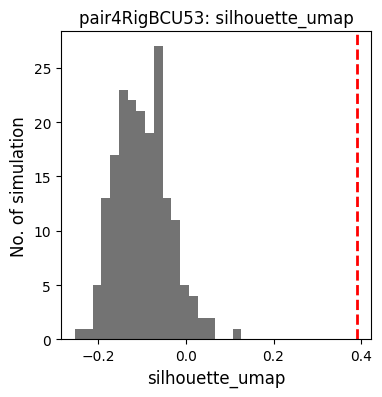

In [49]:
field = 'silhouette_umap'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
d = metrics[field]
bin_width = 0.02
bins = np.arange(min(d), max(d) + bin_width, bin_width)
ax.hist(d, bins=bins, color='#737373', edgecolor='none')
# add a line for the real data
ax.axvline(x=metric_r[field][0], color='red', linestyle='--', linewidth=2)
ax.set_xlabel(field, fontsize=12)
ax.set_ylabel('No. of simulation', fontsize=12)
ax.set_title(f'{bd}: {field}', fontsize=12)
# save as pdf
fn_pdf = os.path.join(fd_save, f'random.hist.{field}.pdf')
fig.savefig(fn_pdf)

### Plot an example random embedding 

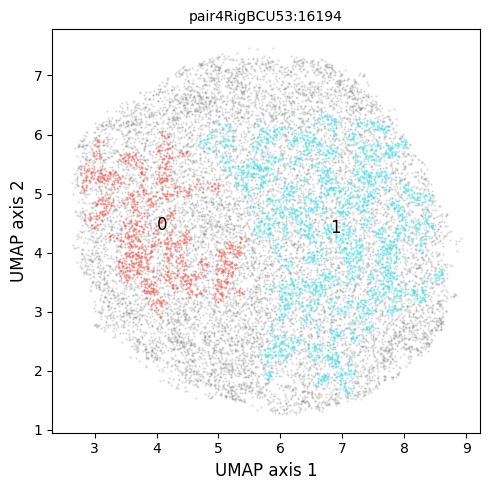

In [50]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(clusterer.labels_)+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(-1, max(clusterer.labels_)+1):
    idx = np.where(clusterer.labels_ == hi)[0]
    embed_s = res[idx,:]
    if hi==-1:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.5, color=col_long[hi])
        # add syl label
        ax.text(np.mean(embed_s[:,0]), np.mean(embed_s[:,1]), hi, fontsize=12)
ax.set_title(f'{bd}:{info.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [51]:
# save the embedding data to plot in Matlab 
embed_r = info.copy()
# save the latent features
for ii in range(latent_rd.shape[1]):
    embed_r[f'vae{ii}'] = latent_rd[:,ii]
# save the UMAP and HDBSCAN results
for ii in range(res.shape[1]):
    embed_r[f'umap{ii+1}'] = res[:,ii]
embed_r['hdbscan_cluster'] = clusterer.labels_+1
embed_r['hdbscan_prob'] = clusterer.probabilities_
fn_csv = os.path.join(fd_save, f'{bd}.random.embedding.csv')
embed_r.to_csv(fn_csv)

In [ ]:
print(fn_csv)

In [ ]:
embed_r.shape